In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras

In [2]:
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [3]:
def trend(time,slope=0):
    return slope*time

In [4]:
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

In [5]:
def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

In [6]:
# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [7]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40

In [8]:
series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise

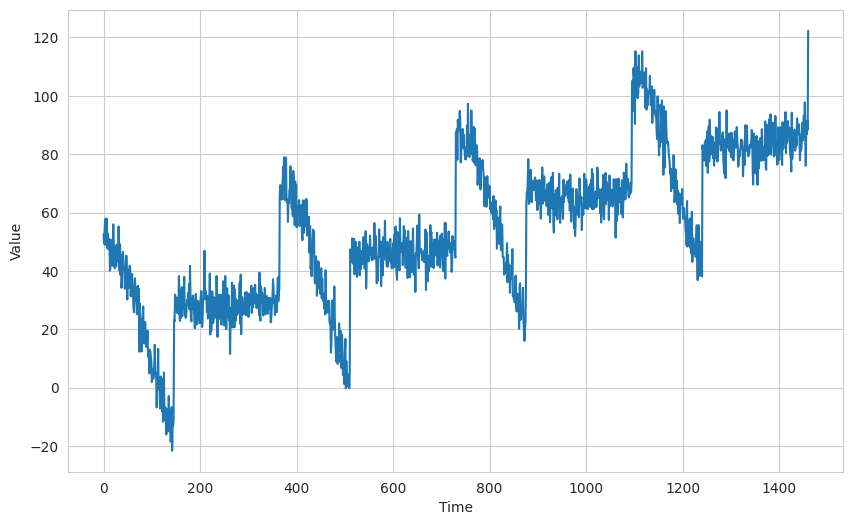

In [9]:
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [10]:
def sequential_window_dataset(series,window_size):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=window_size,drop_remainder=True)
    ds = ds.flat_map(lambda window:window.batch(window_size+1))
    ds = ds.map(lambda window:(window[:-1],window[1:]))
    return ds.batch(1).prefetch(1)

In [11]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [13]:
train_set = sequential_window_dataset(X_train,window_size)

In [14]:
model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, None, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (1, None, 100)            80400     
                                                                 
 dense (Dense)               (1, None, 1)              101       
                                                                 
 lambda (Lambda)             (1, None, 1)              0         
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
lr_schedule = keras.callbacks.LearningRateScheduler(
lambda epoch: 1e-8*10**(epoch/20))

In [17]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

In [18]:
reset_states = ResetStatesCallback()

In [19]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [20]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 13s 80ms/step - loss: 50.3165 - mae: 50.8162 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 2s 47ms/step - loss: 43.1235 - mae: 43.6230 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 2s 52ms/step - loss: 35.4039 - mae: 35.9018 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 2s 56ms/step - loss: 27.6406 - mae: 28.1374 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 2s 66ms/step - loss: 22.2618 - mae: 22.7530 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 2s 51ms/step - loss: 20.2990 - mae: 20.7943 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 2s 53ms/step - loss: 19.1494 - mae: 19.6439 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 2s 50ms/step - loss: 18.3623 - mae: 18.8592 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 2s 46ms/step - loss: 17.7831 - mae

(1e-08, 0.0001, 0.0, 30.0)

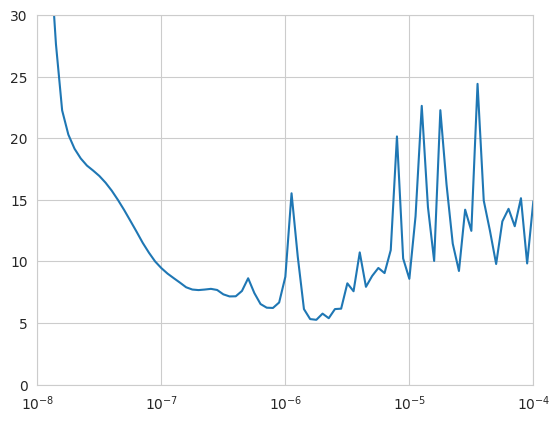

In [21]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])

In [22]:
# Second

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [24]:
window_size = 30
train_set = sequential_window_dataset(X_train,window_size)
valid_set = sequential_window_dataset(X_valid,window_size)

In [25]:
model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [26]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [27]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 5s 38ms/step - loss: 15.7510 - mae: 16.2423 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 1s 27ms/step - loss: 14.9059 - mae: 15.3984 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 1s 27ms/step - loss: 14.4097 - mae: 14.9028 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 1s 26ms/step - loss: 13.6539 - mae: 14.1482 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 1s 26ms/step - loss: 12.5930 - mae: 13.0851 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 1s 29ms/step - loss: 11.6859 - mae: 12.1768 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 1s 27ms/step - loss: 11.1283 - mae: 11.6179 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 1s 27ms/step - loss: 10.7788 - mae: 11.2656 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 1s 27ms/step - loss: 10.5318 - mae:

(1e-08, 0.0001, 0.0, 30.0)

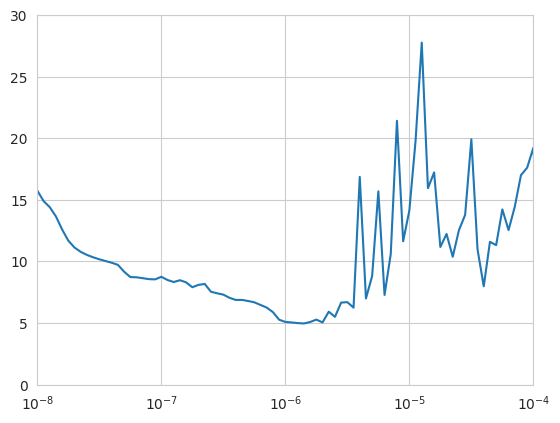

In [28]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])

In [29]:
# Second

In [30]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [31]:
window_size = 30
train_set = sequential_window_dataset(X_train,window_size)
valid_set = sequential_window_dataset(X_valid,window_size)

In [32]:
model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [33]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [34]:
reset_states = ResetStatesCallback()

In [35]:
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)

In [36]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)

In [37]:
model.fit(train_set,epochs=500,
         validation_data=valid_set,callbacks=[early_stopping,model_checkpoint,reset_states])

Epoch 1/500
33/33 [==============================] - 6s 66ms/step - loss: 58.2882 - mae: 58.7875 - val_loss: 20.3095 - val_mae: 20.8066
Epoch 2/500
 4/33 [==>...........................] - ETA: 0s - loss: 20.2498 - mae: 20.7479

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 1s 31ms/step - loss: 25.2059 - mae: 25.7037 - val_loss: 35.8360 - val_mae: 36.3348
Epoch 3/500
33/33 [==============================] - 1s 42ms/step - loss: 10.9504 - mae: 11.4388 - val_loss: 8.1915 - val_mae: 8.6783
Epoch 4/500
33/33 [==============================] - 2s 51ms/step - loss: 10.0805 - mae: 10.5687 - val_loss: 11.0897 - val_mae: 11.5784
Epoch 5/500
33/33 [==============================] - 1s 33ms/step - loss: 13.6195 - mae: 14.1129 - val_loss: 29.4778 - val_mae: 29.9778
Epoch 6/500
33/33 [==============================] - 1s 31ms/step - loss: 11.0389 - mae: 11.5308 - val_loss: 16.5246 - val_mae: 17.0219
Epoch 7/500
33/33 [==============================] - 1s 33ms/step - loss: 7.9884 - mae: 8.4735 - val_loss: 7.9844 - val_mae: 8.4701
Epoch 8/500
33/33 [==============================] - 1s 32ms/step - loss: 9.3007 - mae: 9.7898 - val_loss: 7.9948 - val_mae: 8.4830
Epoch 9/500
33/33 [==============================] - 1s 31ms/step - lo

In [38]:
model = keras.models.load_model("my_checkpoint.h5")

In [39]:
rnn_forecast = model.predict(series[np.newaxis, : ,np.newaxis])

1/1 [==============================] - 1s 1s/step


In [40]:
rnn_forecast = rnn_forecast[0,split_time-1:-1,0]

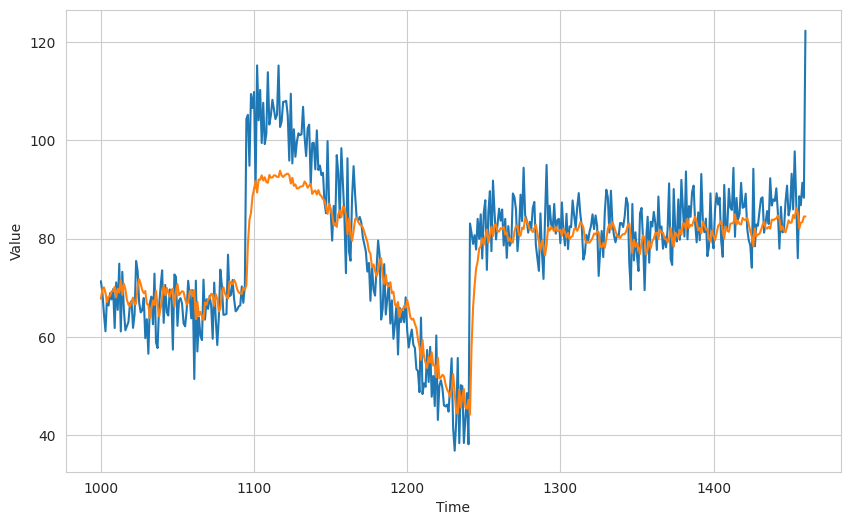

In [41]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

# Forecasting With CNN

In [42]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [43]:
def seq2_seq_window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1],w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [44]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [45]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200),
])

In [46]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

In [47]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [48]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 6s 58ms/step - loss: 30.2434 - mae: 30.7406 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 1s 45ms/step - loss: 29.9681 - mae: 30.4648 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 46ms/step - loss: 29.5300 - mae: 30.0264 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 44ms/step - loss: 29.0001 - mae: 29.4962 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 1s 46ms/step - loss: 28.4070 - mae: 28.9026 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 1s 52ms/step - loss: 27.7913 - mae: 28.2867 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 1s 52ms/step - loss: 27.1758 - mae: 27.6704 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 1s 51ms/step - loss: 26.5906 - mae: 27.0853 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 1s 50ms/step - loss: 26.0306 - mae: 26.5253 - lr: 2.5

(1e-08, 0.0001, 0.0, 30.0)

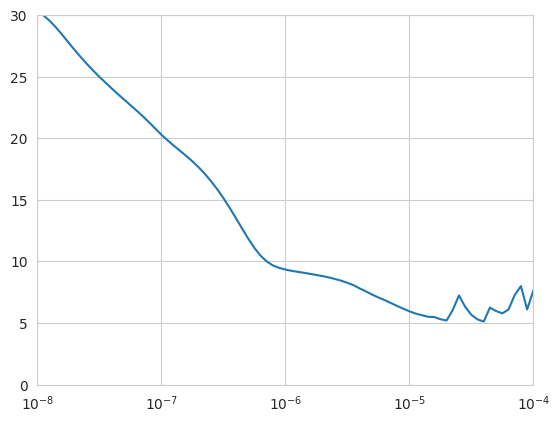

In [49]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])

In [50]:
# Second

In [51]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [52]:
window_size = 30

In [53]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [54]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200),
])

In [55]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,
             metrics=['mae'])

In [56]:
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)

In [57]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set,epochs=500,validation_data=valid_set,
         callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 7s 287ms/step - loss: 22.8743 - mae: 23.3692 - val_loss: 19.1850 - val_mae: 19.6813
Epoch 2/500
8/8 [==============================] - 1s 70ms/step - loss: 13.7945 - mae: 14.2868 - val_loss: 16.1705 - val_mae: 16.6630
Epoch 3/500
8/8 [==============================] - 1s 78ms/step - loss: 10.6470 - mae: 11.1363 - val_loss: 15.4314 - val_mae: 15.9217
Epoch 4/500
8/8 [==============================] - 1s 74ms/step - loss: 8.8981 - mae: 9.3834 - val_loss: 15.0614 - val_mae: 15.5517
Epoch 5/500
8/8 [==============================] - 1s 73ms/step - loss: 8.0129 - mae: 8.4965 - val_loss: 14.8855 - val_mae: 15.3786
Epoch 6/500
8/8 [==============================] - 1s 76ms/step - loss: 7.4729 - mae: 7.9552 - val_loss: 14.4614 - val_mae: 14.9535
Epoch 7/500
8/8 [==============================] - 1s 74ms/step - loss: 7.1938 - mae: 7.6751 - val_loss: 13.3583 - val_mae: 13.8486
Epoch 8/500
8/8 [==============================] - 1s 76ms/step - los

In [58]:
def model_forcast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [59]:
model = keras.models.load_model("my_checkpoint.h5")

In [60]:
rnn_forecast = model_forcast(model,series[:,np.newaxis],window_size)

45/45 [==============================] - 2s 21ms/step


In [61]:
rnn_forecast = rnn_forecast[split_time-window_size:-1,-1,0]

In [62]:
rnn_forecast

array([ 65.40176 ,  67.865135,  67.255356,  67.094925,  66.309616,
        67.96178 ,  67.04765 ,  67.33899 ,  67.33438 ,  68.06626 ,
        67.33807 ,  68.1371  ,  68.26958 ,  68.9565  ,  66.95864 ,
        69.1611  ,  68.104706,  67.99384 ,  65.92272 ,  67.09963 ,
        65.80232 ,  66.09086 ,  65.19039 ,  65.25022 ,  67.09285 ,
        68.24372 ,  67.90129 ,  67.41123 ,  68.83725 ,  68.91075 ,
        67.206406,  66.66013 ,  65.31821 ,  66.10628 ,  65.387215,
        65.07733 ,  65.845215,  66.366425,  65.47525 ,  65.810265,
        66.07577 ,  67.60402 ,  65.58285 ,  68.09287 ,  67.98443 ,
        68.24455 ,  68.076256,  68.76725 ,  66.91282 ,  67.963745,
        68.840256,  67.84344 ,  67.223   ,  68.75676 ,  68.31969 ,
        67.043365,  66.89532 ,  67.012276,  66.84111 ,  67.31775 ,
        66.17338 ,  67.59192 ,  65.972626,  67.25191 ,  65.93588 ,
        65.02278 ,  62.577713,  64.08236 ,  64.10018 ,  64.67573 ,
        64.54296 ,  65.38654 ,  66.68627 ,  66.55261 ,  66.296

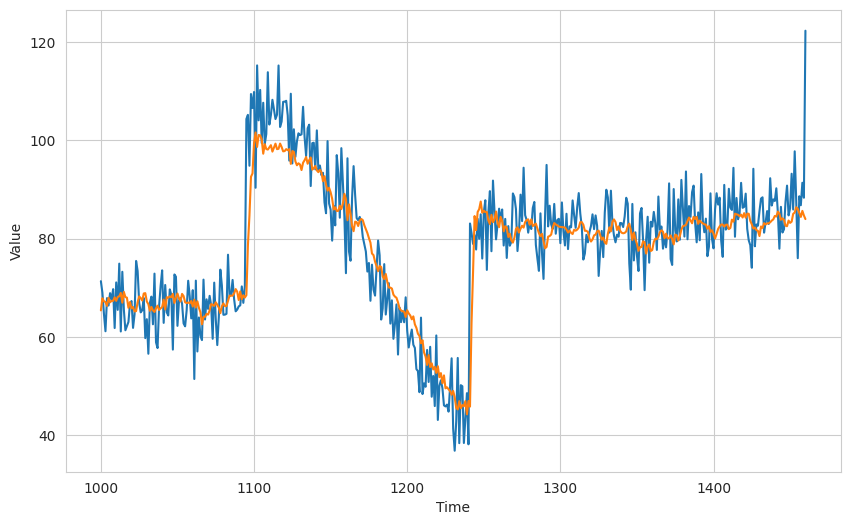

In [63]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

# Fully Convolutional Forcasting

In [64]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 64

In [65]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [66]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
        keras.layers.Conv1D(filters=32,kernel_size=2,strides=1,dilation_rate=dilation_rate,padding='causal',activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1,kernel_size=1))

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          96        
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_6 (Conv1D)           (None, None, 1)           3

In [68]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/30))

In [69]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

In [70]:
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [71]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 51ms/step - loss: 41.1331 - mae: 41.6324 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 1s 47ms/step - loss: 40.2525 - mae: 40.7515 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 1s 51ms/step - loss: 39.2570 - mae: 39.7558 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 1s 53ms/step - loss: 38.0371 - mae: 38.5358 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 1s 56ms/step - loss: 36.4704 - mae: 36.9692 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 1s 50ms/step - loss: 34.4228 - mae: 34.9211 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 1s 52ms/step - loss: 31.5178 - mae: 32.0163 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 1s 52ms/step - loss: 27.4548 - mae: 27.9527 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 1s 56ms/step - loss: 22.0850 - mae: 22.5806 - lr: 1.8

(0.0001, 0.1, 0.0, 30.0)

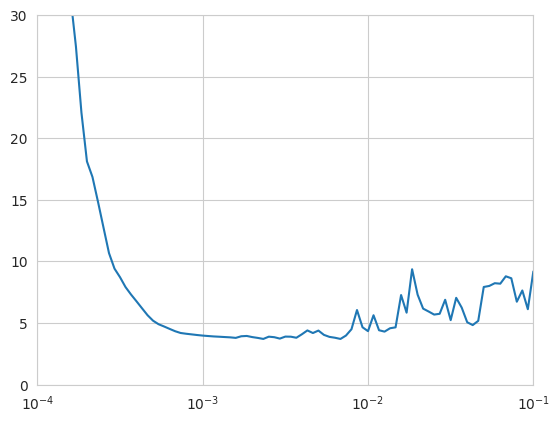

In [72]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-4,1e-1,0,30])

In [73]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 64

In [74]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [75]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
        keras.layers.Conv1D(filters=32,kernel_size=2,strides=1,dilation_rate=dilation_rate,padding='causal',activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1,kernel_size=1))

In [76]:
optimizer = keras.optimizers.Adam(learning_rate=3e-4)

In [77]:
model.compile(loss=keras.callbacks.EarlyStopping(patience=50))
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [78]:
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)
history = model.fit(train_set,epochs=500,validation_data=valid_set,
                   callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 177ms/step - loss: 41.0172 - mae: 41.5165 - val_loss: 75.4738 - val_mae: 75.9738
Epoch 2/500
8/8 [==============================] - 1s 72ms/step - loss: 39.9329 - mae: 40.4319 - val_loss: 72.9472 - val_mae: 73.4472
Epoch 3/500
8/8 [==============================] - 1s 72ms/step - loss: 38.3178 - mae: 38.8165 - val_loss: 68.9522 - val_mae: 69.4522
Epoch 4/500
8/8 [==============================] - 1s 82ms/step - loss: 35.6488 - mae: 36.1471 - val_loss: 62.0374 - val_mae: 62.5374
Epoch 5/500
8/8 [==============================] - 1s 78ms/step - loss: 31.1037 - mae: 31.6019 - val_loss: 50.3757 - val_mae: 50.8757
Epoch 6/500
8/8 [==============================] - 1s 71ms/step - loss: 23.8449 - mae: 24.3422 - val_loss: 31.9654 - val_mae: 32.4631
Epoch 7/500
8/8 [==============================] - 1s 71ms/step - loss: 16.2387 - mae: 16.7319 - val_loss: 25.0559 - val_mae: 25.5519
Epoch 8/500
8/8 [==============================] - 1s 71ms/st

In [79]:
cnn_forecast = model_forcast(model,series[...,np.newaxis],window_size)

44/44 [==============================] - 1s 12ms/step


In [80]:
cnn_forecast = cnn_forecast[split_time-window_size:-1,-1,0]